In [1]:
import os

import librosa
import logging
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.signal
import re

import pickle

from scipy.io import wavfile
import tensorflow as tf
import matplotlib.pyplot as plt


import copy

import feature_extraction_lib as ftelib

# Input files

In [2]:
# Load the train and validation datasets
train_df = pd.read_pickle('../train_physionet_2016_wv.pkl')
val_df = pd.read_pickle('../validation_physionet_2016_wv.pkl')

# Convert the loaded DataFrames to numpy arrays
train_data = train_df[['Patient ID', 'Homomorphic',
                       'CWT_Morl', 'CWT_Mexh', 'Hilbert_Env', 'Labels']].to_numpy()
val_data = val_df[['Patient ID', 'Homomorphic', 'CWT_Morl',
                   'CWT_Mexh', 'Hilbert_Env', 'Labels']].to_numpy()


## Compute Patches

In [3]:
# Process the entire dataset to create patches
def process_dataset(data, patch_size, stride):
    all_features = []
    all_labels = []
    for i in range(data.shape[0]):
        features = np.stack(data[i, 1:5], axis=-1)
        labels = data[i, 5]
        features_patches, labels_patches = ftelib.create_patches(
            features, labels, patch_size, stride)
        all_features.append(features_patches)
        all_labels.append(labels_patches)
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_features, all_labels

### Instantiate the Data Preparers

In [4]:
# Feature creation
BATCH_SIZE = 32 
patch_size = 64
nch = 4
stride = 8


train_features, train_labels = process_dataset(train_data, patch_size, stride)
val_features, val_labels = process_dataset(val_data, patch_size, stride)

# Training Pipeline

In [5]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, UpSampling1D, concatenate

# TODO: provide u-net with one encoder layer only and suggest for them to
# increase its size.
def unet_pcg(nch, patch_size, dropout=0.05):
    inputs = tf.keras.layers.Input(shape=(patch_size, nch))
    conv1 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)
    pool1 = tf.keras.layers.Dropout(dropout)(pool1)

    conv2 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv2)
    pool2 = tf.keras.layers.Dropout(dropout)(pool2)

    conv3 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv3)
    pool3 = tf.keras.layers.Dropout(dropout)(pool3)

    conv4 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv4)
    pool4 = tf.keras.layers.Dropout(dropout)(pool4)

    conv5 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same')(conv5)

    up6_prep = tf.keras.layers.UpSampling1D(size=2)(conv5)

    up6 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(64, 2, padding='same')(up6_prep), conv4], axis=2)
    up6 = tf.keras.layers.Dropout(dropout)(up6)
    conv6 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(conv6)

    up7_prep = tf.keras.layers.UpSampling1D(size=2)(conv6)

    up7 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(64, 2, padding='same')(up7_prep), conv3], axis=2)
    up7 = tf.keras.layers.Dropout(dropout)(up7)
    conv7 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(conv7)

    up8_prep = tf.keras.layers.UpSampling1D(size=2)(conv7)

    up8 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(32, 2, padding='same')(up8_prep), conv2], axis=2)
    up8 = tf.keras.layers.Dropout(dropout)(up8)
    conv8 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(up8)
    conv8 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(conv8)

    up9_prep = tf.keras.layers.UpSampling1D(size=2)(conv8)

    up9 = tf.keras.layers.concatenate([tf.keras.layers.Conv1D(8, 2, padding='same')(up9_prep), conv1], axis=2)
    up9 = tf.keras.layers.Dropout(dropout)(up9)
    conv9 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same')(up9)
    conv9 = tf.keras.layers.Conv1D(8, 3, activation='tanh', padding='same')(conv9)

    conv10 = tf.keras.layers.Conv1D(4, 1, activation='softmax')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    return model

## Hyperparameter Setting

In [6]:
from sklearn.metrics import accuracy_score, precision_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
checkpoint_path = '../pcg_unet_weights/checkpoint_wv.keras'

In [8]:
# tune hyperpararmeter, epochs, e optimizer
# choose adequate metrics
# loss crossentropy, others?
EPOCHS = 15
learning_rate = 1e-4
model = unet_pcg(nch, patch_size=patch_size)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                  metrics=['CategoricalAccuracy', 'Precision', 'Recall'])


In [9]:
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
history = model.fit(train_features, train_labels,
                    validation_data=(val_features, val_labels),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    shuffle=True, callbacks=[model_checkpoint])

Epoch 1/15
10460/10460 [==============================] - 1096s 105ms/step - loss: 0.5563 - categorical_accuracy: 0.7960 - precision: 0.8505 - recall: 0.7384 - val_loss: 0.4455 - val_categorical_accuracy: 0.8365 - val_precision: 0.8666 - val_recall: 0.8063
Epoch 2/15
10460/10460 [==============================] - 1379s 132ms/step - loss: 0.4635 - categorical_accuracy: 0.8291 - precision: 0.8632 - recall: 0.7944 - val_loss: 0.4245 - val_categorical_accuracy: 0.8432 - val_precision: 0.8716 - val_recall: 0.8152
Epoch 3/15
10460/10460 [==============================] - 1061s 101ms/step - loss: 0.4469 - categorical_accuracy: 0.8345 - precision: 0.8672 - recall: 0.8017 - val_loss: 0.4170 - val_categorical_accuracy: 0.8457 - val_precision: 0.8795 - val_recall: 0.8110
Epoch 4/15
10460/10460 [==============================] - 1145s 109ms/step - loss: 0.4375 - categorical_accuracy: 0.8375 - precision: 0.8697 - recall: 0.8056 - val_loss: 0.4131 - val_categorical_accuracy: 0.8467 - val_precision: 

In [10]:
model.load_weights(checkpoint_path)

## Inference pipeline
Collect the predictions of the U-Net

In [11]:

predictions_train = model.predict(train_features)
val_test = model.predict(val_features)

2693/2693 [==============================] - 15s 5ms/step


## Post processing

In [12]:
def reconstruct_original_data(patched_data, original_lengths, patch_size, stride):
    """
    Reconstruct the original sequences from patched data.

    Parameters
    ----------
    patched_data : numpy.ndarray
        Patched data array of shape (Num_Patches, Patch_Size, Num_Features).
    original_lengths : list
        List of original lengths for each patient sequence.
    patch_size : int
        The number of samples for each patch.
    stride : int
        The number of samples to stride between patches.

    Returns
    -------
    reconstructed_data : list of numpy.ndarray
        List containing the reconstructed data for each patient.
    """
    reconstructed_data = []
    current_idx = 0

    for original_length in original_lengths:
        # Initialize arrays to hold the reconstructed sequence and overlap count
        reconstructed = np.zeros((original_length, patched_data.shape[-1]))
        overlap_count = np.zeros(original_length)

        num_patches = int(np.floor((original_length - patch_size) / stride)) + 1
        adjusted_stride_samples = (
            (original_length - patch_size) / (num_patches - 1)
            if num_patches > 1 else stride
        )
        adjusted_stride_samples = int(round(adjusted_stride_samples))

        # Iterate over patches and reconstruct the sequence
        for i in range(num_patches):
            start_idx = i * adjusted_stride_samples
            end_idx = min(start_idx + patch_size, original_length)

            reconstructed[start_idx:end_idx] += patched_data[current_idx, :end_idx - start_idx, :]
            overlap_count[start_idx:end_idx] += 1

            current_idx += 1

        # Average the overlapping regions
        reconstructed /= np.maximum(overlap_count[:, None], 1)
        reconstructed_data.append(reconstructed)

    return reconstructed_data


original_lengths = [len(seq) for seq in val_data[:, 1]]  # Get original lengths from validation data
reconstructed_labels = reconstruct_original_data(val_test, original_lengths, patch_size, stride)



## Temporal sequencing

In [13]:
def max_temporal_modelling(seq, num_states=4):
  for t in range(1, len(seq)):
    if seq[t] != seq[t-1] and seq[t] != ((seq[t-1] + 1) % num_states):
      seq[t] = seq[t-1]
  return seq

test_seq = np.array([1, 1, 1, 2, 1, 2, 2, 3, 3, 0, 3])
exp_seq = np.array([1, 1, 1, 2, 2, 2, 2, 3, 3, 0, 0])

max_temporal_modelling(test_seq)
assert np.all(exp_seq == test_seq)

# Evaluation - metrics Schmidt

In [14]:
def reverse_one_hot_encoding(one_hot_encoded_data, desired_order=[0, 1, 2, 3]):
    """
    Reverse the one-hot encoding to get the original labels.

    Parameters
    ----------
    one_hot_encoded_data : numpy.ndarray
        One-hot encoded data of shape (Num_Samples, Num_Classes).
    desired_order : list
        List representing the label order used during one-hot encoding.

    Returns
    -------
    labels : numpy.ndarray
        Array of decoded labels of shape (Num_Samples,).
    """
    # Use argmax to find the index of the maximum value in each one-hot encoded row
    label_indices = np.argmax(one_hot_encoded_data, axis=1)
    labels = np.array([desired_order[idx] for idx in label_indices])
    return labels


original_lengths = [len(seq) for seq in val_data[:, 1]]  # Get original lengths from validation data
reconstructed_labels = reconstruct_original_data(val_test, original_lengths, patch_size, stride)

pred_labels = [reverse_one_hot_encoding(pred) for pred in reconstructed_labels]

prediction_labels = copy.deepcopy(pred_labels)

ground_truth = [reverse_one_hot_encoding(pred) for pred in val_data[:, 5]]

predictions = np.array([max_temporal_modelling(prediction) for prediction in prediction_labels], dtype=object)

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score
def extract_state_runs(labels, desired_states):
    """
    Extract continuous runs of the desired states from labels.

    Args:
        labels: numpy array of labels.
        desired_states: set of desired state values.

    Returns:
        A list of dictionaries with keys:
            'start': start index of the run
            'end': end index of the run (inclusive)
            'midpoint': midpoint index of the run
            'state': the state value (0 or 2)
    """
    # Ensure labels is a 1D array
    labels = np.asarray(labels).flatten()

    runs = []
    N = len(labels)
    in_run = False
    run_start = 0
    run_state = None

    for i in range(N):
        label_i = labels[i]
        # If label_i is an array (e.g., from a structured array), extract scalar
        if isinstance(label_i, np.ndarray):
            label_i = label_i.item()
        if label_i in desired_states:
            if not in_run:
                # Start of a new run
                in_run = True
                run_start = i
                run_state = label_i
        else:
            if in_run:
                # End of the run
                run_end = i - 1
                midpoint = (run_start + run_end) // 2
                runs.append({
                    'start': run_start,
                    'end': run_end,
                    'midpoint': midpoint,
                    'state': run_state
                })
                in_run = False
                run_state = None
    # Check if we're still in a run at the end
    if in_run:
        run_end = N - 1
        midpoint = (run_start + run_end) // 2
        runs.append({
            'start': run_start,
            'end': run_end,
            'midpoint': midpoint,
            'state': run_state
        })
    return runs

def compute_ppv_sensitivity(ground_truth, predictions, sample_rate, threshold=60e-3):
    """
    Compute PPV and sensitivity for states 0 and 2.

    Args:
        ground_truth: numpy array of ground truth labels.
        predictions: numpy array of predicted labels.
        sample_rate: sampling rate in Hz.

    Returns:
        ppv: Positive Predictive Value.
        sensitivity: Sensitivity (Recall).
    """
    # Ensure ground_truth and predictions are 1D arrays
    ground_truth = np.asarray(ground_truth).flatten()
    predictions = np.asarray(predictions).flatten()

    # Desired states
    desired_states = {0, 2}

    # Maximum distance in samples (treshold in seconds vs fs)
    max_distance_samples = int(threshold * sample_rate)

    # Extract runs from ground truth and predictions
    gt_runs = extract_state_runs(ground_truth, desired_states)
    pred_runs = extract_state_runs(predictions, desired_states)

    # Get midpoints and states
    gt_midpoints = np.array([run['midpoint'] for run in gt_runs])
    gt_states = np.array([run['state'] for run in gt_runs])

    pred_midpoints = np.array([run['midpoint'] for run in pred_runs])
    pred_states = np.array([run['state'] for run in pred_runs])

    # Initialize matches
    matched_gt_indices = set()
    matched_pred_indices = set()

    # Build potential matches
    potential_matches = []
    for i, (p_mid, p_state) in enumerate(zip(pred_midpoints, pred_states)):
        for j, (gt_mid, gt_state) in enumerate(zip(gt_midpoints, gt_states)):
            if gt_state == p_state:
                distance = abs(p_mid - gt_mid)
                if distance <= max_distance_samples:
                    potential_matches.append((i, j, distance))

    # Sort potential matches by distance
    potential_matches.sort(key=lambda x: x[2])

    # Perform matching
    TP = 0
    for i, j, d in potential_matches:
        if i not in matched_pred_indices and j not in matched_gt_indices:
            matched_pred_indices.add(i)
            matched_gt_indices.add(j)
            TP += 1

    # Compute FP and FN
    total_pred = len(pred_midpoints)
    total_gt = len(gt_midpoints)
    FP = total_pred - len(matched_pred_indices)
    FN = total_gt - len(matched_gt_indices)

    # Compute PPV and Sensitivity
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

    return ppv, sensitivity

# Example usage:
# Assuming you have numpy arrays `ground_truth_labels` and `predicted_labels`, and `sample_rate`.

# ground_truth_labels = np.array([...])  # Your ground truth labels
# predicted_labels = np.array([...])     # Your predicted labels
# sample_rate = 1000  # Example sample rate in Hz


def compute_schmidt_metrics(ground_truth, sequences, sample_rate):
  ppvs, sensitivities, accuracies = [], [], []
  for i in range(len(ground_truth)):
    ppv, sensitivity = compute_ppv_sensitivity(ground_truth[i],
                                               sequences[i],
                                               50)
    ppvs.append(ppv)
    sensitivities.append(sensitivity)
    accuracies.append(accuracy_score(ground_truth[i], sequences[i]))
  return np.array(ppvs), np.array(sensitivities), np.array(accuracies)


ppv, sens, acc = compute_schmidt_metrics(ground_truth, predictions, 50)

## Inspect Results

In [16]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_predictions(ground_truth, seqs, idx):

  # Define the window width in terms of seconds and convert to the corresponding sample range
  window_duration = 0.1  # 0.06 ms in seconds
  sample_interval = 1 / 50  # Time per sample in seconds (20 ms per sample at 50 Hz)

  # Calculate the equivalent width in terms of sample indices (will be <1)
  window_width_samples = window_duration / sample_interval

  # Create the plot
  plt.figure(figsize=(24, 6))

  # Plot ground truth and predictions with discrete markers and dotted lines
  plt.plot(ground_truth[idx], 'o--', label='Ground Truth', markersize=6)
  plt.plot(seqs[idx], 'o--', color='red', label='Predictions', markersize=6)


  # Set labels and legend
  plt.title(f'Signal at idx {idx} with 0.06 ms reference window')
  plt.xlabel('Sample Index')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.grid(True)
  plt.show()

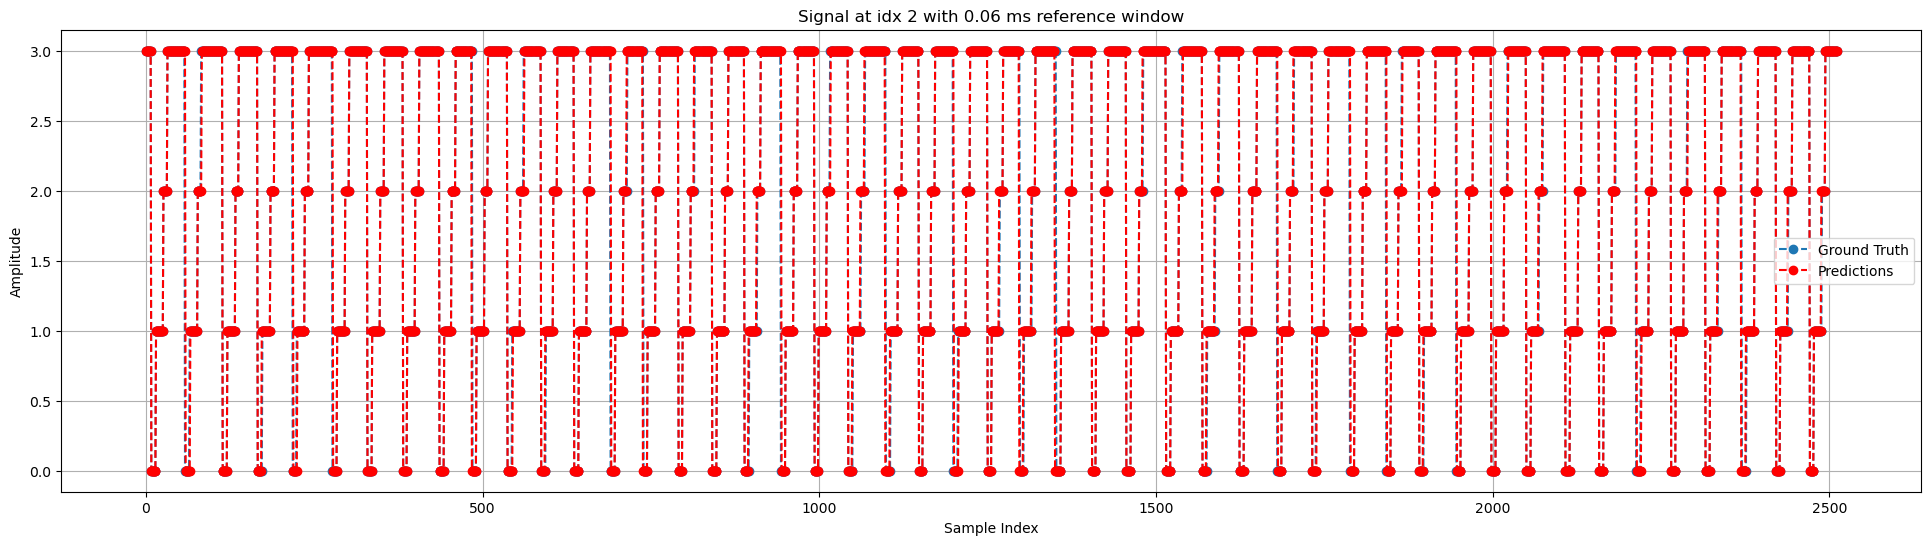

(1.0, 1.0, 0.9773089171974523)

In [17]:
idx = 2
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

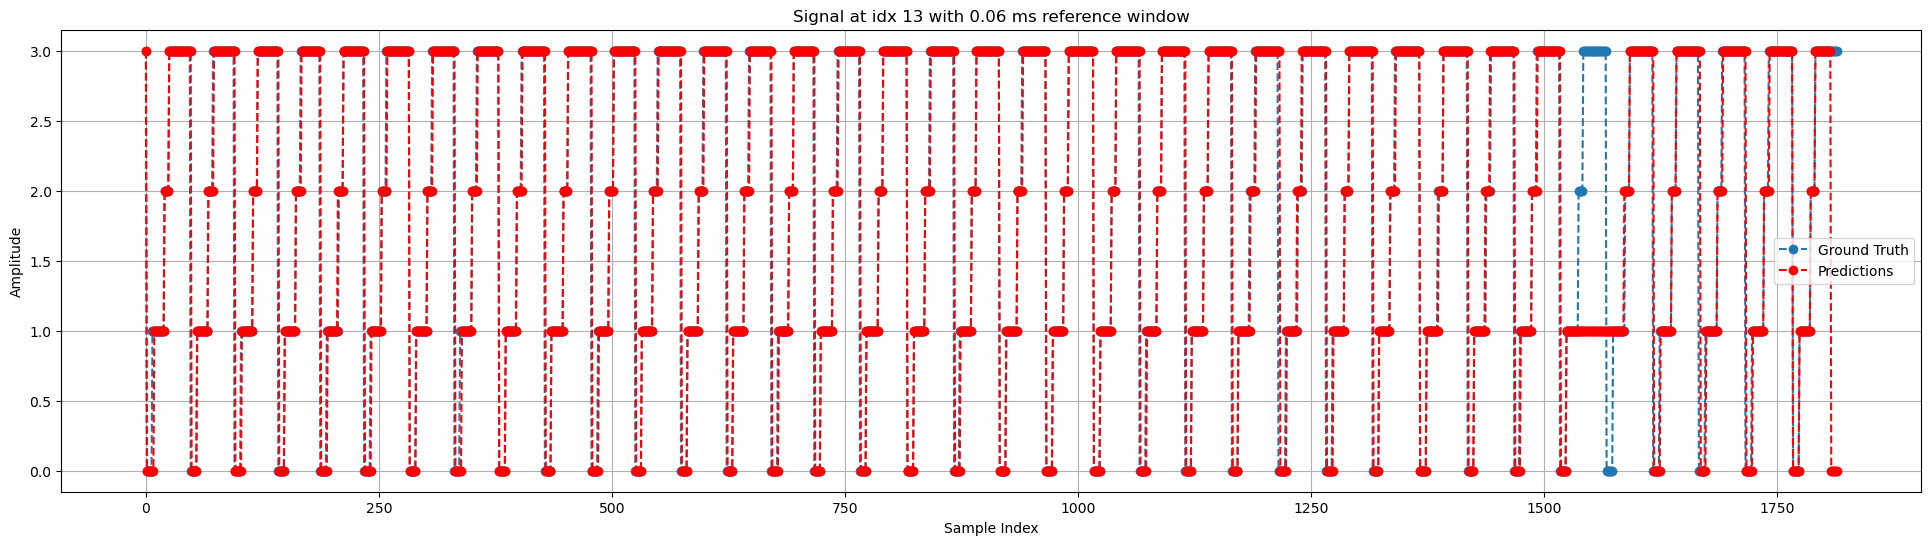

(0.9863013698630136, 0.972972972972973, 0.9366391184573003)

In [18]:
idx = 13
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

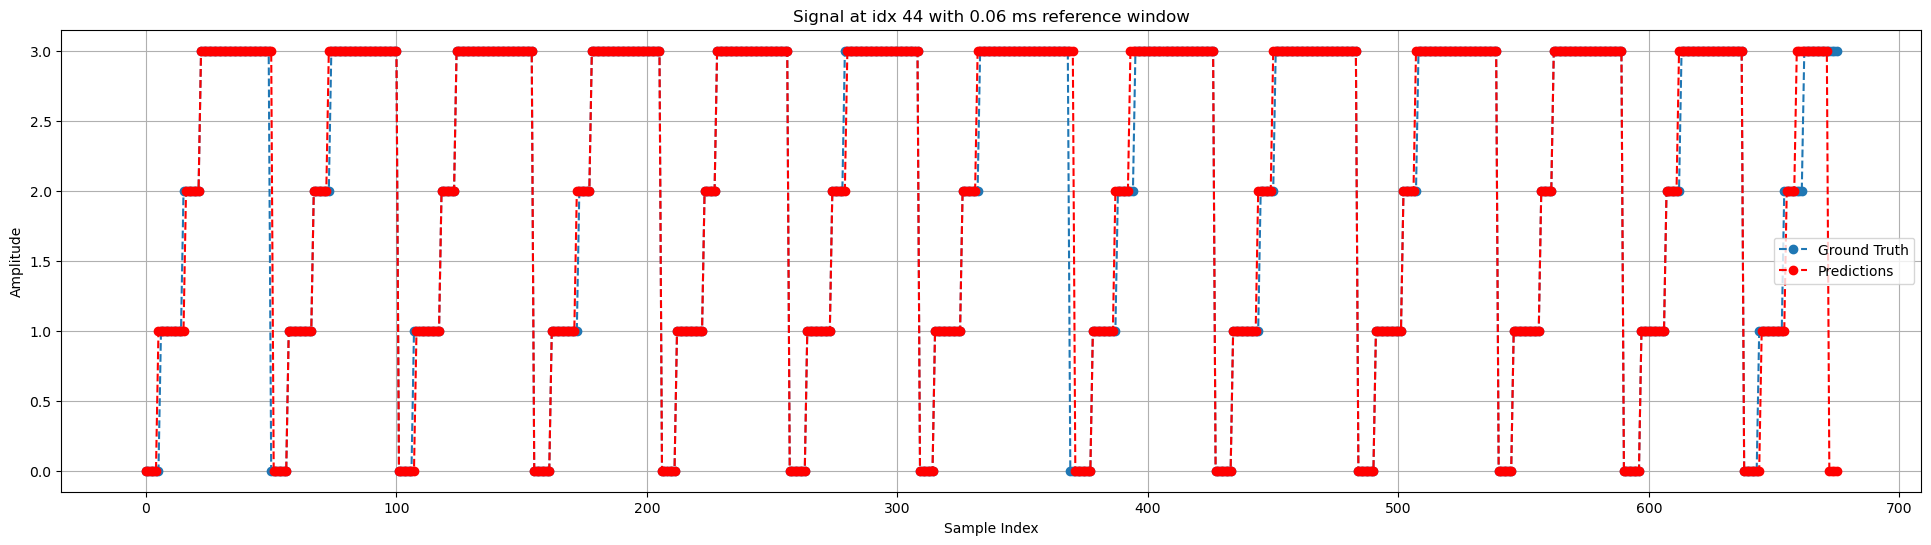

(0.9629629629629629, 1.0, 0.9615384615384616)

In [19]:
idx = 44
visualize_predictions(ground_truth, predictions, idx)
ppv[idx], sens[idx], acc[idx]

## Histogram of metrics

Text(0, 0.5, 'Count')

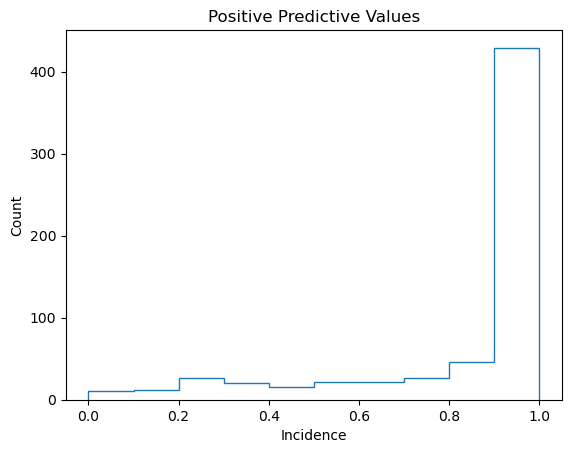

In [20]:
counts, bins = np.histogram(ppv)
plt.stairs(counts, bins)
plt.title('Positive Predictive Values')
plt.xlabel('Incidence')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

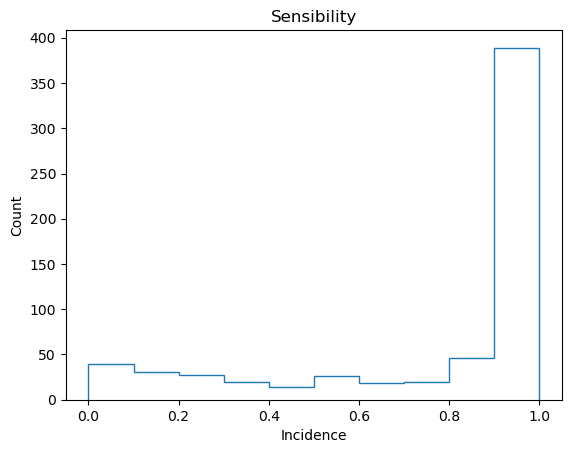

In [21]:
counts, bins = np.histogram(sens)
plt.stairs(counts, bins)
plt.title('Sensibility')
plt.xlabel('Incidence')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

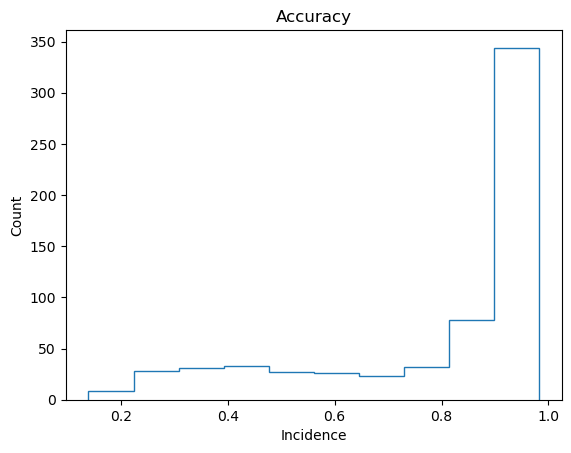

In [22]:
counts, bins = np.histogram(acc)
plt.stairs(counts, bins)
plt.title('Accuracy')
plt.xlabel('Incidence')
plt.ylabel('Count')